In [2]:
import numpy as np
import os
import tensorflow as tf
import iris
import matplotlib.pyplot as plt
from neural_network_decision_tree import nn_decision_tree
from DataParser import DataParser
from CsvParser  import CsvParser
%matplotlib inline

In [3]:
tf.__version__

'1.15.0'

In [4]:
np.random.seed(1943)
tf.set_random_seed(1943)

In [5]:
print('iris.feature shape is %d rows by %d columns ' % (iris.feature.shape))
print('iris.label shape is %d rows by %d columns' % (iris.label.shape))

iris.feature shape is 150 rows by 4 columns 
iris.label shape is 150 rows by 3 columns


In [6]:
data_dir        = os.path.join(os.getcwd(), 'datasets')
signal_file     = 'ap_100MeV_L1L1_loose.csv'
background_file = 'tritrig-wab-beam_100MeV_L1L1_loose.csv'

In [7]:
background = CsvParser(os.path.join(data_dir, background_file))
signal     = CsvParser(os.path.join(data_dir, signal_file))

myData     = DataParser(signal=signal, background=background)

[INFO]: Reading CSV file C:\Users\carag\Google Drive\PhD\Classes\CS230\project\repo\past_work\DNDT-master\DNDT-master\tensorflow\datasets\tritrig-wab-beam_100MeV_L1L1_loose.csv found 217012 rows and 31 columns
[INFO]: Found 31 features and 217012 samples
[INFO]: Filtering data removing these columns ['vx', 'vz']
[INFO]: Cleaning data
[INFO]: Cleaned 98259 samples 
[INFO]: Reading CSV file C:\Users\carag\Google Drive\PhD\Classes\CS230\project\repo\past_work\DNDT-master\DNDT-master\tensorflow\datasets\ap_100MeV_L1L1_loose.csv found 30290 rows and 31 columns
[INFO]: Found 31 features and 30290 samples
[INFO]: Filtering data removing these columns ['vx', 'vz']
[INFO]: Cleaning data
[INFO]: Cleaned 675 samples 


In [8]:
# x = iris.feature[:, 2:4]  # use "Petal length" and "Petal width" only
# y = iris.label
# d = x.shape[1]

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

x = myData.X.T

y = convert_to_one_hot(myData.Y, 2).T
d = x.shape[1]

In [9]:
print(np.mean(x, axis=0))

[0.14388973 6.10160396]


In [10]:
num_cut = [1, 1]  # "Petal length" and "Petal width"
num_leaf = np.prod(np.array(num_cut) + 1)
num_class = 2

In [11]:
print([i for i in num_cut])

[1, 1]


In [12]:
sess = tf.InteractiveSession()

In [13]:
x_ph = tf.placeholder(tf.float32, [None, d])
y_ph = tf.placeholder(tf.float32, [None, num_class])

In [14]:
cut_points_list = [tf.Variable(tf.random_uniform([i])) for i in num_cut]
leaf_score = tf.Variable(tf.random_uniform([num_leaf, num_class]))

In [15]:
print(leaf_score)

<tf.Variable 'Variable_2:0' shape=(4, 2) dtype=float32_ref>


In [16]:
y_pred = nn_decision_tree(x_ph, cut_points_list, leaf_score, temperature=0.1)
loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(logits=y_pred, onehot_labels=y_ph))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
print(y_pred)
print(y_ph.shape)

Tensor("MatMul_2:0", shape=(?, 2), dtype=float32)
(?, 2)


In [18]:
opt = tf.train.AdamOptimizer(0.1)
train_step = opt.minimize(loss)

In [19]:
sess.run(tf.global_variables_initializer())

In [20]:
for i in range(1000):
    _, loss_e = sess.run([train_step, loss], feed_dict={x_ph: x, y_ph: y})
    if i % 200 == 0:
        print(loss_e)
        
error_rate = (1 - np.mean(np.argmax(y_pred.eval(feed_dict={x_ph: x}), axis=1) == np.argmax(y, axis=1)))
print('error rate %.2f' % error_rate)

0.92958105
0.16066125
0.16055232
0.16055222
0.16055222
error rate 0.04


In [21]:
sample_x0 = np.repeat(np.linspace(np.min(x[:,0]), np.max(x[:,0]), 100), 100).reshape(-1,1)
sample_x1 = np.tile(np.linspace(np.min(x[:,1]), np.max(x[:,1]), 100).reshape(-1,1), [100,1])
sample_x = np.hstack([sample_x0, sample_x1])
sample_label = np.argmax(y_pred.eval(feed_dict={x_ph: sample_x}), axis=1)

Text(0.5, 1.0, 'Error 3.9 %')

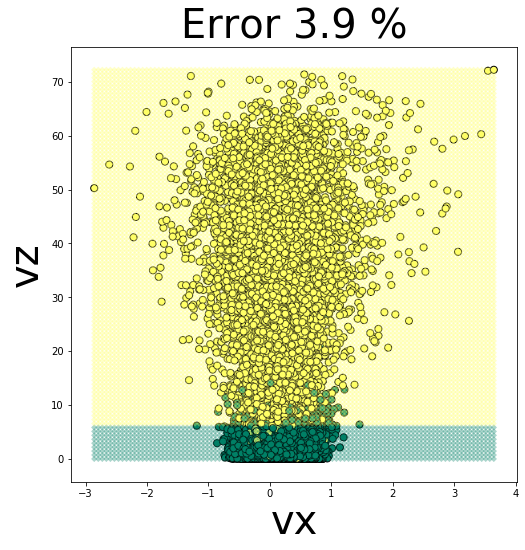

In [25]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x[:,0], 
            x[:,1], 
            c=np.argmax(y, axis=1), 
            marker='o',
            s=50,
            cmap='summer', 
            edgecolors='black')

ax.scatter(sample_x0.flatten(), 
            sample_x1.flatten(), 
            c=sample_label.flatten(), 
            marker='D',
            s=20,
            cmap='summer', 
            edgecolors='none',
            alpha=0.33)

ax.set_xlabel('vx', fontsize=40)
ax.set_ylabel('vz', fontsize=40)
ax.set_title('Error %.1f %%' % (error_rate * 100), fontsize=40)
